In [17]:
from __future__ import (unicode_literals, print_function, absolute_import,
                        division)


from ema_workbench import (Model, MultiprocessingEvaluator, Policy,
                           Scenario, IntegerParameter)
from ema_workbench.em_framework.evaluators import BaseEvaluator

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
import time
from problem_formulation import get_model_for_problem_formulation
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt


In [18]:

results = pd.read_csv("Optimizationresults 100K.csv") 
#Sum the different RfR values to identify the one with 0 for the our municiaplites. identify intresting solutions
results ["sum rfr"] = (results ['0_RfR 0'] + 
                       results ['0_RfR 1'] +
                       results ['0_RfR 2'] +
                       results ['1_RfR 0'] + 
                       results ['1_RfR 1'] +
                       results ['1_RfR 2'] +
                       results ['2_RfR 0'] + 
                       results ['2_RfR 1'] +
                       results ['2_RfR 2'])




results ["sum deaths"] = (results ['A.1_Expected Number of Deaths'] + 
                       results ['A.2_Expected Number of Deaths'] +
                       results ['A.3_Expected Number of Deaths'] +
                       results ['A.4_Expected Number of Deaths'] + 
                       results ['A.5_Expected Number of Deaths'])
                     


int_sol = results[results["sum rfr"] <= 0 ] #no RFR costs for dikes
int_solu = int_sol[int_sol['A.1_Expected Number of Deaths'] <= 0 ] #no deaths in dike 1
int_solut = int_solu[int_solu['A.2_Expected Number of Deaths'] <= 0.00148 ] #0.00148 for dike 2
int_solutions = int_solut[int_solut['A.3_Expected Number of Deaths'] <= 0.001 ] #0.001 for dike 3
# int_solutions

int_solutions


,Unnamed: 0,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,...,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,sum rfr,sum deaths
277,277,0,0,0,0,0,0,0,0,0,...,1.261015e+08,0.0,2.225849e+07,0.000000,3.337712e+07,0.000000,0.0,0.000000,0,0.001058
558,558,0,0,0,0,0,0,0,0,0,...,3.422156e+07,0.0,6.348950e+06,0.004159,2.503721e+07,0.000000,242400000.0,0.000000,0,0.004159
683,683,0,0,0,0,0,0,0,0,0,...,6.226744e+07,0.0,1.428414e+07,0.003766,1.087498e+08,0.065523,0.0,0.000000,0,0.069288
832,832,0,0,0,0,0,0,0,0,0,...,2.879840e+07,0.0,1.808200e+07,0.000000,1.134436e+08,0.014069,0.0,5103.412196,0,0.014069
1221,1221,0,0,0,0,0,0,0,0,0,...,1.362141e+08,0.0,1.692524e+07,0.000000,1.377821e+08,0.070516,0.0,0.000000,0,0.070516


In [21]:
opt_results.keys()

Index(['Unnamed: 0', '0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1',
       '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1',
       '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
       'A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs',
       'A.2_Expected Number of Deaths', 'A.3 Total Costs',
       'A.3_Expected Number of Deaths', 'A.4 Total Costs',
       'A.4_Expected Number of Deaths', 'A.5 Total Costs',
       'A.5_Expected Number of Deaths', 'RfR Total Costs',
       'Expected Evacuation Costs'],
      dtype='object')

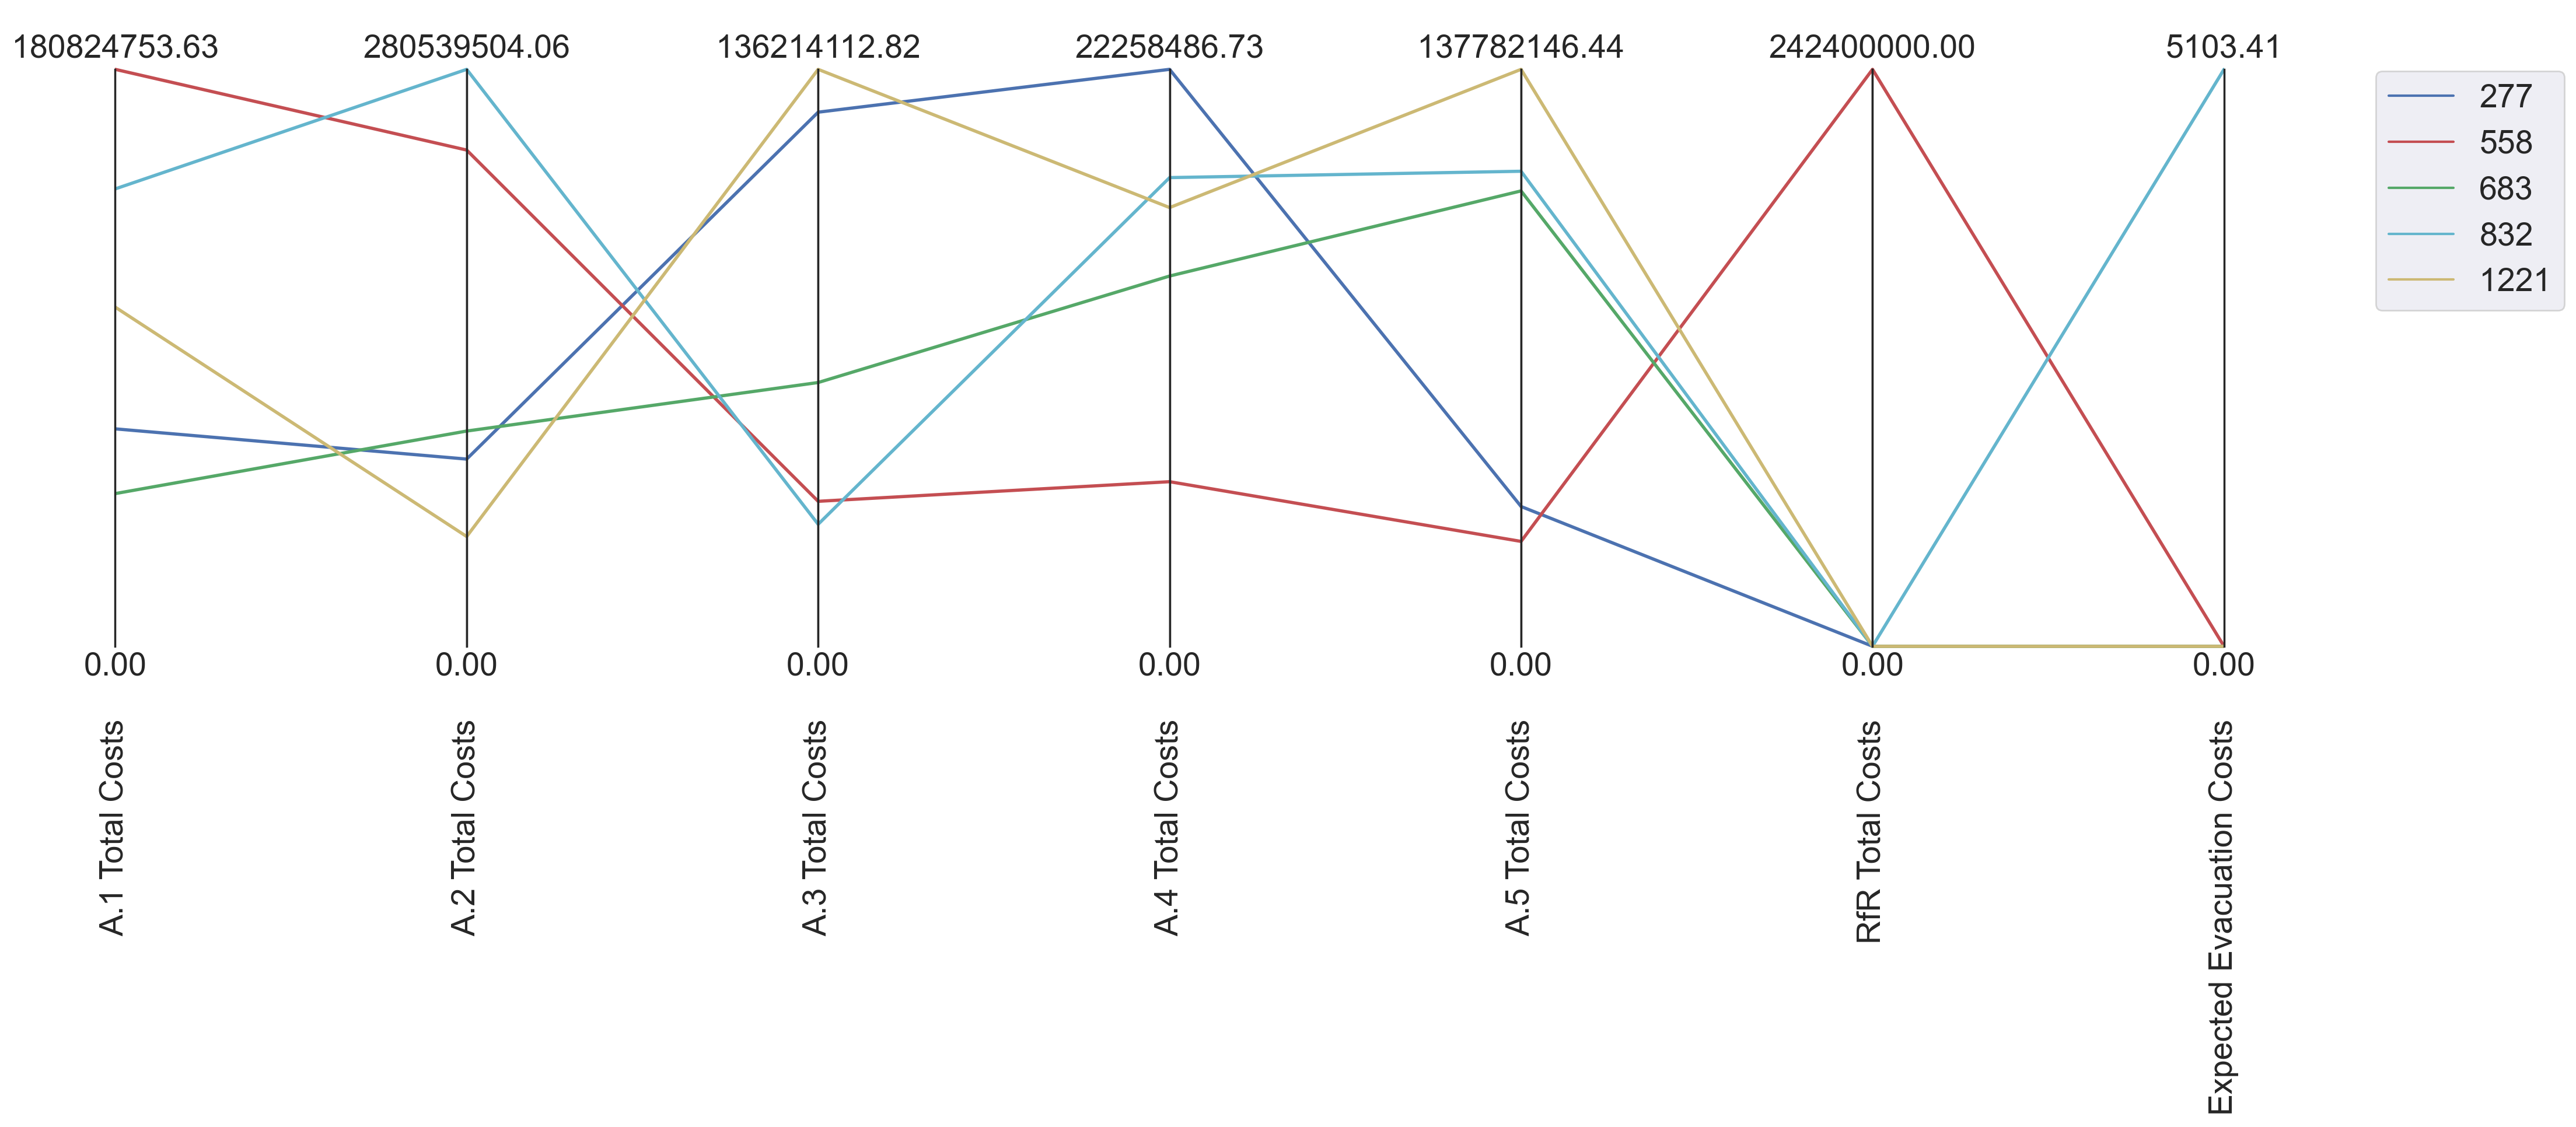

In [71]:
from ema_workbench.analysis import parcoords
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import cm
import numpy as np


data = int_solutions.loc[:, ['A.1 Total Costs', 'A.2 Total Costs',
               'A.3 Total Costs','A.4 Total Costs',
               'A.5 Total Costs','RfR Total Costs',
               'Expected Evacuation Costs']]
limits = parcoords.get_limits(data)
limits.loc[0, ['A.1 Total Costs', 'A.2 Total Costs',
               'A.3 Total Costs','A.4 Total Costs',
               'A.5 Total Costs','RfR Total Costs',
               'Expected Evacuation Costs']] = 0

paraxes = parcoords.ParallelAxes(limits, fontsize=20)

colors=['b', 'r','g', 'c', 'y', 'k',]

#labels
for i, (index, row) in enumerate(data.iterrows()):
    plt.rcParams['figure.figsize'] = [20,10]
    plt.rcParams['figure.dpi'] = 200
    sns.set(font_scale=1.5)
    paraxes.plot(row.to_frame().T, label=str(index), color =colors[i], linewidth=2)
paraxes.legend()


# paraxes.plot(data)

plt.show()

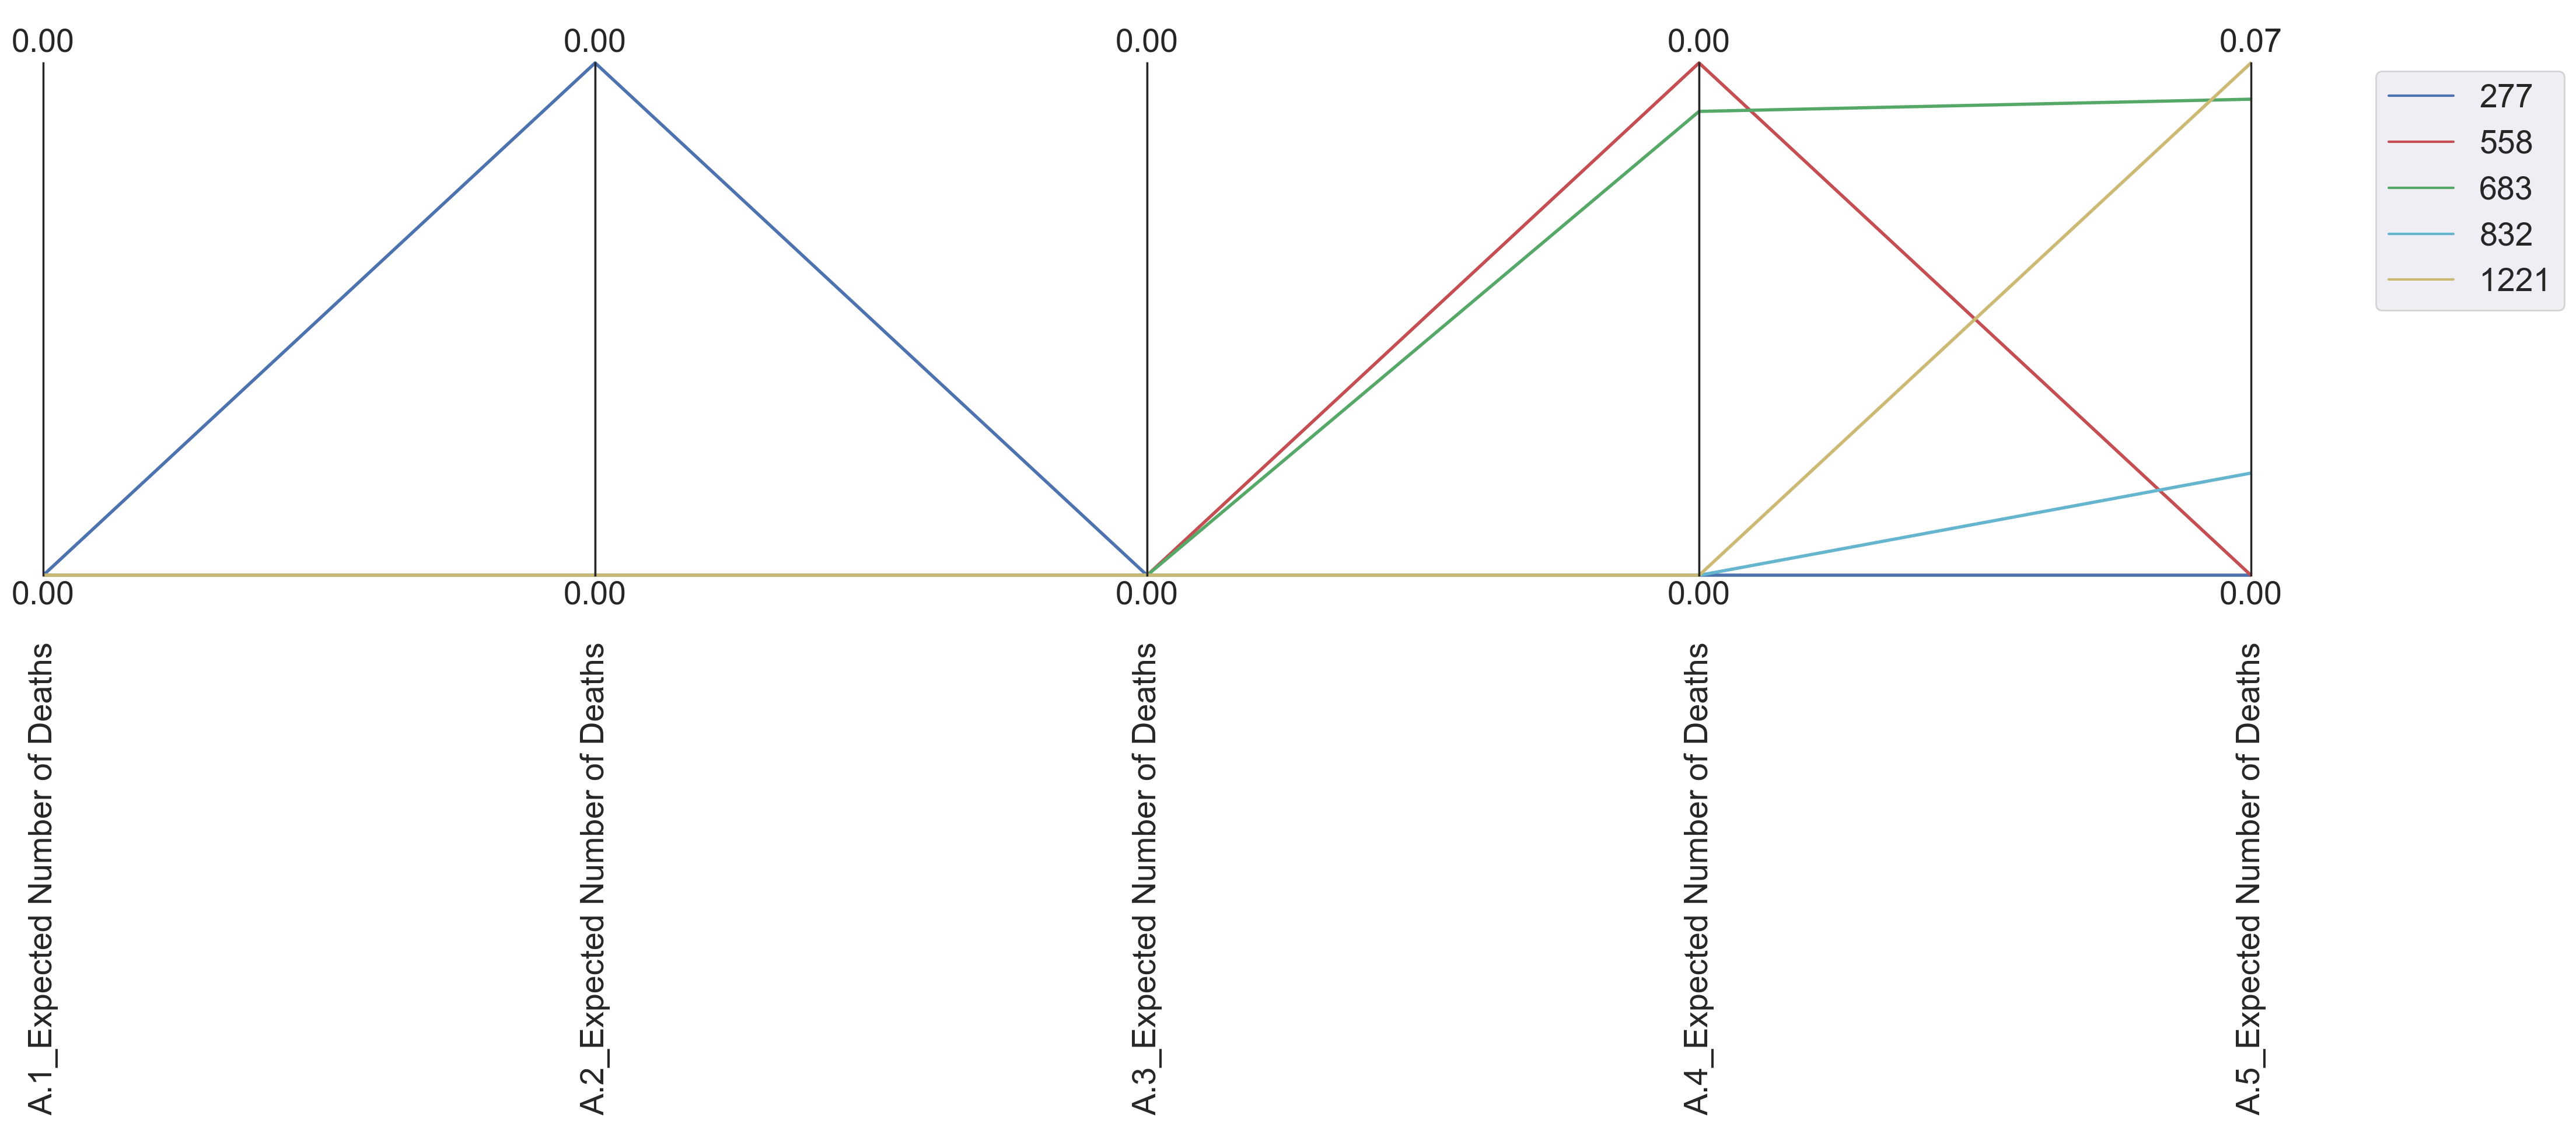

In [70]:
from ema_workbench.analysis import parcoords

data = int_solutions.loc[:, ['A.1_Expected Number of Deaths', 'A.2_Expected Number of Deaths',
                           'A.3_Expected Number of Deaths','A.4_Expected Number of Deaths',
                           'A.5_Expected Number of Deaths']]
limits = parcoords.get_limits(data)
limits.loc[0, ['A.1_Expected Number of Deaths', 'A.2_Expected Number of Deaths',
                           'A.3_Expected Number of Deaths','A.4_Expected Number of Deaths',
                           'A.5_Expected Number of Deaths']] = 0

paraxes = parcoords.ParallelAxes(limits, fontsize=20)

colors=['b', 'r','g', 'c', 'y', 'k',]

#labels
for i, (index, row) in enumerate(data.iterrows()):
    plt.rcParams['figure.figsize'] = [20,10]
    plt.rcParams['figure.dpi'] = 200
    sns.set(font_scale=1.5)
    paraxes.plot(row.to_frame().T, label=str(index), color =colors[i],  linewidth=2)
paraxes.legend()


# paraxes.plot(data)

plt.show()

In [30]:
int_solutions.to_csv(r'intsolutions.csv')

In [14]:
from ema_workbench import load_results

results = load_results('SECOND candidate solutions MORDM 1000scenarios.tar.gz')
experiments, outcomes = results

In [16]:
experiments.head()


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,45.0,334.338219,1.5,0.384455,48.791951,1.5,0.243866,332.087341,10.0,0.272985,...,2.0,7.0,1.0,0.0,4.0,0.0,0.0,0,277,dikesnet
1,115.0,167.703202,10.0,0.443832,57.738115,1.0,0.350760,123.453385,1.5,0.678659,...,2.0,7.0,1.0,0.0,4.0,0.0,0.0,1,277,dikesnet
2,67.0,40.526313,10.0,0.844840,84.297462,1.0,0.032855,88.744746,1.5,0.004323,...,2.0,7.0,1.0,0.0,4.0,0.0,0.0,2,277,dikesnet
3,77.0,82.259809,10.0,0.305028,116.595805,10.0,0.020959,342.847398,10.0,0.614126,...,2.0,7.0,1.0,0.0,4.0,0.0,0.0,3,277,dikesnet
4,3.0,184.237540,1.0,0.656921,88.684076,1.5,0.509033,308.089112,1.5,0.472518,...,2.0,7.0,1.0,0.0,4.0,0.0,0.0,4,277,dikesnet


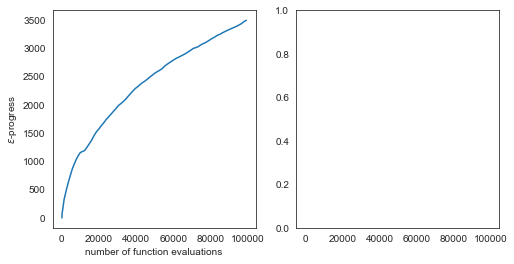

In [19]:
convergence = pd.read_csv("Convergenceresults 100K.csv") 

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax1.set_xlabel('number of function evaluations') 
plt.show()